In [1]:
from IPython.display import clear_output
!wget https://disk.karelia.pro/djnSMfz/Трек%201.%20Онежское%20озеро.tgz?attachment
import os
try:
    os.mkdir("./data")
except: pass
!tar -xvzf "Трек 1. Онежское озеро.tgz?attachment" -C ./data
clear_output()

In [2]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
# переводим дату в числа
def date_to_data(frame, holidays=None,
                 drop=False, name="date", suffix=""):
    assert name in frame, "Нужна колонка с датой"
    date = frame[name].dt

    info = pd.concat([date.days_in_month,
                     date.month,
                     date.quarter,
                     date.month % 12 // 3 + 1,
                     date.hour], axis=1)
    
    info.columns = ["days_in_month", "month",
                    "quarter", "season", "hour"]

    temp = pd.concat([date.isocalendar(),
                      info], axis=1)

    temp.columns = temp.columns + suffix
    frame = pd.concat([frame, temp], axis=1)
    if drop:
        return frame.drop([name], axis=1)
    return frame

In [5]:
import pandas as pd
import os

df = pd.DataFrame(os.listdir("./data"), columns=["name"])
df["time_parsed"] = pd.to_datetime(df["name"].apply(lambda x: x[:-4]))
df = df.sort_values(by="time_parsed")
df = date_to_data(df, name="time_parsed")
df["date"] = df["time_parsed"].dt.date

In [6]:
# df["y"] = 0
# df.loc[df.month.isin([1, 2]), "y"] = 1
# df.loc[(df.month == 12) & (df.day >= 5), "y"] = 1
# df.loc[(df.month == 3) & (df.day <= 10), "y"] = 1

In [7]:
from datetime import datetime

def compare(date):
    d = datetime(date.year, date.month, date.day, date.hour)
    if d < datetime(2016, 4, 17, 10):
        return 1
    if d > datetime(2016, 12, 28, 4) and d < datetime(2017, 4, 28, 8):
        return 1
    if d > datetime(2018, 1, 10, 6) and d < datetime(2018, 5, 3, 12):
        return 1
    if d > datetime(2018, 12, 18, 6) and d < datetime(2019, 4, 23,10):
        return 1
    if d > datetime(2020, 1, 30, 10) and d < datetime(2020, 3, 13, 18):
        return 1
    if d > datetime(2021, 1, 4, 14):
        return 1
    return 0

In [8]:
df["y"] = df["time_parsed"].apply(lambda x: compare(x))

In [9]:
df.head()

,name,time_parsed,year,week,day,days_in_month,month,quarter,season,hour,date,y
5297,201603010000.jpg,2016-03-01 00:00:00,2016,9,2,31,3,1,2,0,2016-03-01,1
17809,201603010200.jpg,2016-03-01 02:00:00,2016,9,2,31,3,1,2,2,2016-03-01,1
12889,201603010600.jpg,2016-03-01 06:00:00,2016,9,2,31,3,1,2,6,2016-03-01,1
366,201603010800.jpg,2016-03-01 08:00:00,2016,9,2,31,3,1,2,8,2016-03-01,1
9593,201603011000.jpg,2016-03-01 10:00:00,2016,9,2,31,3,1,2,10,2016-03-01,1


In [10]:
import os
from tqdm.notebook import tqdm
from PIL import Image

class LakeDataset(Dataset):
    def __init__(self, path, df, transform, size=(600, 600)):
        self.transform = transform
      
        filenames = []
        for name, y in df.values:
            filenames.append([os.path.join(path, name),
                              torch.tensor(y).long()])

        self.images = []
        for filename, y in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    image = image.resize(size)
                    self.images.append([image.copy(), y])
            except:
                print('Could not load image:', filename)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        X = self.transform(img[0])
        return X, img[1]

In [11]:
# size = (128, 128)

# transform_all = transforms.Compose([
#     transforms.RandomResizedCrop(size[0]),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.CenterCrop(size[0]),
#     transforms.RandomVerticalFlip(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                           std=[0.229, 0.224, 0.225])
# ])

In [12]:
size = (128, 128)

transform_all = transforms.Compose([
    transforms.ToTensor()
])

In [13]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df[["name", "y"]],
                                      test_size=0.01, random_state=42)

In [14]:
train_dataset = LakeDataset("data", train_df, transform_all, size=size)
train_dataset = DataLoader(train_dataset, batch_size=64, shuffle=True)

valid_dataset = LakeDataset("data", valid_df, transform_all, size=size)
valid_dataset = DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [15]:
import torchvision.models as models
import random
import numpy as np

# Сидим модель
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Подргружаем модель
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 2)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [16]:
def accuracy(model, val):
    total = 0
    correct = 0
    for X, y in val:
        res = model(X.to(device))
        res = res.argmax(dim=1)
        total += res.shape[0]
        correct += (res == y.to(device)).sum().item()
    return correct / total

Iterations: 1 Score: 0.8627450980392157
Iterations: 2 Score: 0.8529411764705882
Iterations: 3 Score: 0.8921568627450981
Iterations: 4 Score: 0.8921568627450981
Iterations: 5 Score: 0.8872549019607843
Iterations: 6 Score: 0.8823529411764706
Iterations: 7 Score: 0.9019607843137255



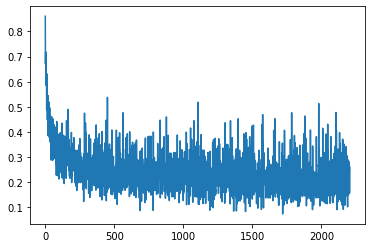

In [17]:
train_losses = []
num_epochs = 7

for epoch in tqdm(range(num_epochs)):
    model.train()
    for X, y in train_dataset:
        optimizer.zero_grad()
        output = model(X.to(device))
        loss = criterion(output, y.to(device))
        loss.backward()
        train_losses.append(loss.item())
        optimizer.step()
    model.eval()
    val_score = accuracy(model, valid_dataset)
    print(f"Iterations: {epoch + 1} Score: {val_score}")

plt.plot(train_losses)
plt.show()

In [20]:
model.eval()
accuracy(model, valid_dataset)

0.9019607843137255

In [19]:
torch.save(model, "network.pth")